In [1]:
!wget -nc 140.114.76.113:8000/ccpd6000.zip
!unzip -nq ccpd6000.zip
!ls -alh

File ‘ccpd6000.zip’ already there; not retrieving.

total 317M
drwxr-xr-x 1 root root 4.0K Dec 11 04:56 .
drwxr-xr-x 1 root root 4.0K Dec 11 04:53 ..
drwxr-xr-x 4 root root 4.0K Dec 11 05:07 ccpd6000
-rw-r--r-- 1 root root 317M Nov 19 11:44 ccpd6000.zip
drwxr-xr-x 1 root root 4.0K Dec  6 16:53 .config
drwxr-xr-x 3 root root 4.0K Dec 11 04:56 runs
drwxr-xr-x 1 root root 4.0K Dec  6 16:53 sample_data


In [2]:
!sha256sum ccpd6000.zip

977d7124a53e565c3f2b371a871ee04ebbe572f07deb0b38c5548ddaae0cb2c9  ccpd6000.zip


In [0]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display

import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as transforms
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

In [4]:
device = torch.device("cuda:0")
# device = 'cuda'     # the computing device, 'cuda' or 'cpu'
print(device)

cuda:0


In [0]:
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
train_epoch = 13 # the max epoch to train the model

# Some pathes
cwd = Path('.')
data_fldr = cwd / 'ccpd6000'
train_img_fldr = data_fldr / 'train_images'
test_img_fldr = data_fldr / 'test_images'
train_label = data_fldr / 'train.csv'
test_label = data_fldr / 'test.csv'
csv_save = data_fldr / 'prediction.csv'

In [0]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

In [0]:
pre_ps = transforms.Compose([
    transforms.Resize((IMG_SIZE[1], IMG_SIZE[0])),
    transforms.ToTensor()
])

In [0]:
class TrainData(Dataset):
    def __init__(self, csv_path, fldr_path):
        super().__init__()
        self.fldr = Path(fldr_path)
        self.csv = pd.read_csv(csv_path).to_dict('records')
        self.trans = pre_ps

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.csv)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img = Image.open(self.fldr / self.csv[idx]['name'])
        normal_x = img.size[0]
        normal_y = img.size[1]
        img = img.convert('RGB')
        img = self.trans(img)
        kpts = torch.tensor([
            self.csv[idx]['BR_x']/normal_x, self.csv[idx]['BR_y']/normal_y,
            self.csv[idx]['BL_x']/normal_x, self.csv[idx]['BL_y']/normal_y,
            self.csv[idx]['TL_x']/normal_x, self.csv[idx]['TL_y']/normal_y,
            self.csv[idx]['TR_x']/normal_x, self.csv[idx]['TR_y']/normal_y])
        return img, kpts

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


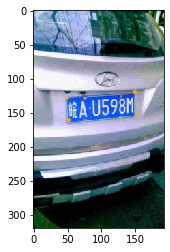

In [9]:
# Do some checking and visualization
data = TrainData(train_label, train_img_fldr)
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = transforms.functional.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
        
class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((4, 4)),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            nn.MaxPool2d((2, 2)),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d((2, 2)),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d((2, 2)),
            ConvBlock(128, 64),
            ConvBlock(64, 32),
            nn.MaxPool2d((2, 2)),
        )
        self.regression = nn.Sequential(
            nn.Flatten(), nn.Linear(480, 32), nn.ReLU(), nn.Linear(32, 8), nn.Sigmoid()
        )

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and 
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        img_b = self.features(img_b)
        kpt_b = self.regression(img_b)
        
        return kpt_b


# Do some checking
loader = DataLoader(data, batch_size=10) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
# device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([10, 3, 320, 192])
torch.Size([10, 8])
tensor(0.1412, device='cuda:0', grad_fn=<L1LossBackward>)


Epoch 000:
train loss: 0.0016142152104659249
valid loss: 0.0006171513651694976
Epoch 001:
train loss: 0.0005004750380816648
valid loss: 0.0005017399459374848
Epoch 002:
train loss: 0.0003295163106147461
valid loss: 0.00036474326659996314
Epoch 003:
train loss: 0.00028705901871693506
valid loss: 0.0005135745677299861
Epoch 004:
train loss: 0.00029591802697848904
valid loss: 0.000292862480248806
Epoch 005:
train loss: 0.00021489684612594474
valid loss: 0.00020786172782378745
Epoch 006:
train loss: 0.0001708875182177287
valid loss: 0.000206854929767699
Epoch 007:
train loss: 0.00019490641622027678
valid loss: 0.00022288563417594375
Epoch 008:
train loss: 0.00015617409329150245
valid loss: 0.00021969889644809636
Epoch 009:
train loss: 0.00018827954270544747
valid loss: 0.00027260375411399657
Epoch 010:
train loss: 0.0001868221604496155
valid loss: 0.00021760839827346883
Epoch 011:
train loss: 0.0001469063998183438
valid loss: 0.000191556134283882
Epoch 012:
train loss: 0.000131516189304196

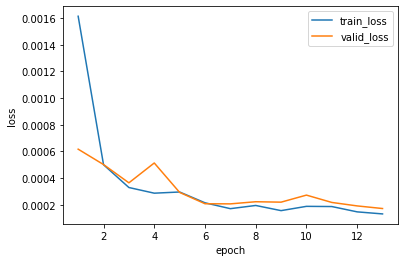

In [11]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(train_label, train_img_fldr)
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 10, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False, num_workers=4)
        self.visul_loader = DataLoader(self.visul_set, 10, shuffle=False)

        # model, loss function, optimizer
        self.device = device
        self.model = Net().to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.max_epoch = train_epoch

    def run(self):
        metrics = {'train_loss': [], 'valid_loss': []}

        for self.epoch in range(self.max_epoch): # 5 epochs
            train_loss = self.train() # train 1 epoch
            valid_loss = self.valid() # valid 1 epoch
            self.visul()              # visualization

            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)

        # Save the parameters(weights) of the model to disk
        torch.save(self.model.state_dict(), self.log_dir / 'model.pth')
        
        # Plot the loss curve against epoch
        x = np.arange(1, self.max_epoch+1)
        plt.plot(x, np.array(metrics['train_loss']))
        plt.plot(x, np.array(metrics['valid_loss']))
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend(['train_loss', 'valid_loss'], loc='upper right')
        plt.savefig(self.log_dir / 'metrics.png')

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        
        running_loss = 0
        for i, (img, kpts) in enumerate(self.train_loader):
            img = img.to(self.device)
            kpts = kpts.to(self.device)
            
            self.optimizer.zero_grad()
            p = self.model(img)
            loss = self.criterion(p, kpts)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.detach().item()
        
        return running_loss / i

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        
        running_loss = 0
        for i, (img, kpts) in enumerate(self.valid_loader):
            img = img.to(self.device)
            kpts = kpts.to(self.device)
            
            p = self.model(img)
            loss = self.criterion(p, kpts)
            
            running_loss += loss.detach().item()
        
        return running_loss / i

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='cyan')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
m = Trainer(log_dir)
m.run()

In [0]:
class TestData(Dataset):
    def __init__(self, fldr_path):
        super().__init__()
        self.fldr = Path(fldr_path)
        self.trans = pre_ps

    def __len__(self):
        '''Return the number of sample
        '''
        return 3000

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            filename: (str) filename of the returned test image
        '''
        filename = f'{idx:04d}.jpg'
        img = Image.open(self.fldr / filename)
        img = img.convert('RGB')
        img = self.trans(img)
        return img, filename

torch.Size([3, 320, 192])
tensor(1.)
1472.jpg


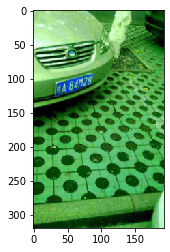

torch.Size([10, 3, 320, 192])


In [13]:
test_data = TestData(test_img_fldr)
rand_idx = np.random.randint(0, 3000)
test_img, filename = test_data[rand_idx] # get a sample
print(test_img.size())   # should be [3, H, W]
print(test_img.max())    # should be <= 1.0
print(filename)

test_img = transforms.functional.to_pil_image(test_img) # convert tensor of shape (3, H, W) to PIL.Image
plt.imshow(test_img)
plt.show()

test_loader = DataLoader(test_data, batch_size=10)
img_b, _ = next(iter(test_loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]

In [14]:
# Do testing
test_kpt = [FIELDS]
test_filename = []

# Plot progress bar
show_iter = 25
print('0%', end='')

for i in range(int(300/show_iter)): # 300 = 3000/batch_size
    print('-', end='')
    
print('100%\n |', end='')

with torch.no_grad():
    for i, (img, filename) in enumerate(test_loader):
        img = img.to(device)
        
        m.model.eval()
        
        test_pred = m.model(img)
        
        test_kpt += test_pred.tolist()
        test_filename += list(filename)
        
        if i % show_iter == (show_iter-1):
            print('-',end='')

print("|\nFinish Testing!")

0%------------100%
 |------------|
Finish Testing!


In [15]:
df = pd.DataFrame(test_kpt)
df.columns = df.iloc[0]
df = df.drop([0])
df[['BR_x', 'BL_x', 'TL_x', 'TR_x']] *= 720
df[['BR_y', 'BL_y', 'TL_y', 'TR_y']] *= 1160
df.insert(0, "name", test_filename)
df.to_csv(csv_save, index=False)
df

,name,BR_x,BR_y,BL_x,BL_y,TL_x,TL_y,TR_x,TR_y
1,0000.jpg,393.152,615.103,213.016,567.368,206.146,517.414,379.922,560.094
2,0001.jpg,448.894,546.811,282.714,534.427,279.526,480.538,443.317,488.537
3,0002.jpg,456.41,517.14,349.393,514.849,354.358,476.608,456.943,477.354
4,0003.jpg,508.845,604.796,304.32,581.69,299.501,519.714,501.203,539.689
5,0004.jpg,448.848,597.841,158.023,593.789,151.701,521.629,442.26,518.536
...,...,...,...,...,...,...,...,...,...
2996,2995.jpg,458.763,655,301.356,626.646,291.904,573.027,451.615,593.48
2997,2996.jpg,517.5,642.73,339.42,633.478,328.434,567.529,512.827,575.04
2998,2997.jpg,331.234,385.538,163.368,375.46,164.409,344.184,320.226,344.296
2999,2998.jpg,456.744,570.695,156.651,536.502,144.78,462.556,443.85,485.772


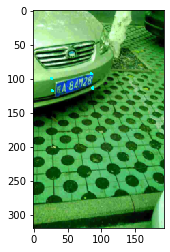

In [16]:
test_img_o = Image.open(test_img_fldr / df.loc[rand_idx+1]['name'])
test_x = test_img_o.size[0]
test_y = test_img_o.size[1]
test_kpt = torch.tensor([
    df.loc[rand_idx+1]['BR_x']/test_x, df.loc[rand_idx+1]['BR_y']/test_y,
    df.loc[rand_idx+1]['BL_x']/test_x, df.loc[rand_idx+1]['BL_y']/test_y,
    df.loc[rand_idx+1]['TL_x']/test_x, df.loc[rand_idx+1]['TL_y']/test_y,
    df.loc[rand_idx+1]['TR_x']/test_x, df.loc[rand_idx+1]['TR_y']/test_y])

test_vis = draw_kpts(test_img, test_kpt, c='cyan')
plt.imshow(test_vis)
plt.show()

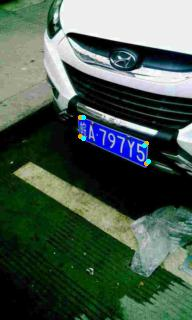

In [17]:
display.Image(str(log_dir / '004' / '000.jpg')) # A visualization of training data in epoch 4

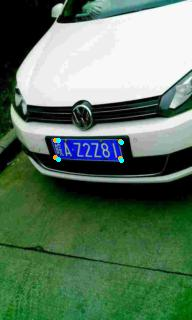

In [18]:
display.Image(str(log_dir / '004' / '025.jpg')) # A visualization of validation data in epoch 4

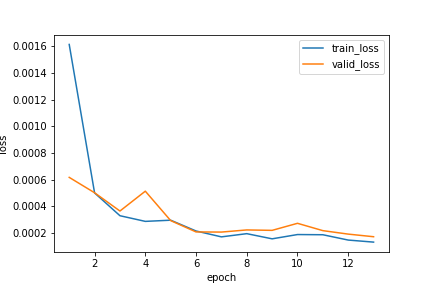

In [19]:
display.Image(str(log_dir / 'metrics.png')) # Loss

In [20]:
!curl -F "file=@./ccpd6000/prediction.csv" -X POST 140.114.76.113:5000/cs6550 -i

HTTP/1.1 100 Continue

HTTP/1.0 200 OK
Content-Type: application/json
Content-Length: 16
Server: Werkzeug/0.16.0 Python/3.7.5
Date: Wed, 11 Dec 2019 05:21:11 GMT

{"rmse":15.809}
